# Simulações Deposição Aleatoria - 16 amostras

In [6]:
# importação dos objetos
from deposicao import DeposicaoAleatoria
from rng import RNG
import numpy as np
import pdb
from multiprocessing import Pool

def calcular_seeds_rng (numero_geradores, L, t_max):
    rng = RNG(0)
    seeds = [0]
    print('0% das seeds computadas')
    for i in range(1, numero_geradores):
        for j in range(t_max * L):
            rng.rng()
        seeds.append(rng.xn)
        print('{}% das seeds computadas'.format(i * 100 / numero_geradores))
    print('100% das seeds computadas\n')
    return seeds

def simular(deposicao):
    deposicao.simular()
    return deposicao

instancias_paralelas = 4
amostras = 4 * instancias_paralelas
tempo_maximo = 10000
#comprimentos_subestratos = [100, 200, 400]
comprimentos_subestratos = [400]
z = 1
coeficiente_tempo_maximo = 0

dados_medios = {
    L:  {
        'evolucao_subestratos': {
            t: np.zeros(L) for t in range(max(tempo_maximo, round(coeficiente_tempo_maximo * (L ** z))))
        },
        'interfaces': np.zeros(L),
        'tempo_maximo': (max(tempo_maximo, round(coeficiente_tempo_maximo * (L ** z)))),
        'rugosidades': np.zeros(max(tempo_maximo, round(coeficiente_tempo_maximo * (L ** z))))
    }
    for L in comprimentos_subestratos
}

for L in comprimentos_subestratos:
    tempo_maximo = dados_medios[L]['tempo_maximo']
    # computar sequencia de seeds para manter o estado do gerador de numeros
    # aleatorios entre amostras distintas
    print('Calculando as Seeds do Gerador de Numeros Aleatorios')
    seeds = calcular_seeds_rng(instancias_paralelas, L, tempo_maximo)
    
    for amostra in range(0,amostras,instancias_paralelas):
        # instancio instancias_paralelas de objetos de deposicao aleatoria
        instancias = []
        for i in range(instancias_paralelas):
            instancias.append(
                DeposicaoAleatoria(L, RNG(seeds[i]), tempo_maximo = tempo_maximo)
            )
            
        # simulacao de instancias_paralelas deposicoes
        print('Simulacao das amostras {} a {}'.format(amostra + 1, amostra + instancias_paralelas))
        pool = Pool()
        deposicoes = pool.map(simular, instancias)
        pool.close()
        
        # armazenar resultados
        for deposicao in deposicoes:
            for t in range(deposicao.tempo_maximo):
                dados_medios[L]['evolucao_subestratos'][t] += np.array([deposicao.altura_sitio(i, t) for i in range(L)]) / amostras
            dados_medios[L]['interfaces'] += np.array([deposicao.altura_sitio(i) for i in range(L)]) / amostras
            dados_medios[L]['rugosidades'] += np.array(deposicao.rugosidade()) / amostras
        
        # atualizar seeds
        for s in seeds:
            s.rng.xn += deposicao.rng.xn
        seeds = [d.rng.xn for d in deposicoes]

Calculando as Seeds do Gerador de Numeros Aleatorios
0% das seeds computadas
25.0% das seeds computadas
50.0% das seeds computadas
75.0% das seeds computadas
100% das seeds computadas

Simulacao das amostras 1 a 4
0.0%   0.0%   0.0%   0.0%   5.0%   5.0%   5.0%   5.0%   10.0%   10.0%   10.0%   10.0%   15.0%   15.0%   15.0%   15.0%   20.0%   20.0%   20.0%   20.0%   25.0%   25.0%   30.0%   30.0%   30.0%   30.0%   35.0%   35.0%   35.0%   35.0%   40.0%   40.0%   40.0%   40.0%   45.0%   45.0%   45.0%   45.0%   50.0%   50.0%   50.0%   50.0%   55.0%   55.0%   55.0%   55.0%   60.0%   60.0%   60.0%   60.0%   65.0%   65.0%   65.0%   65.0%   70.0%   70.0%   70.0%   70.0%   75.0%   75.0%   75.0%   75.0%   80.0%   80.0%   80.0%   80.0%   85.0%   85.0%   85.0%   85.0%   90.0%   90.0%   90.0%   90.0%   95.0%   95.0%   95.0%   95.0%   



Simulacao das amostras 5 a 8
0.0%   0.0%   0.0%   0.0%   5.0%   5.0%   5.0%   5.0%   10.0%   10.0%   10.0%   10.0%   15.0%   15.0%   15.0%   15.0%   20.0%   20.0%   2

## Gráfico da Média da Evolução do Crescimento de Subestratos - Deposição Aleatoria

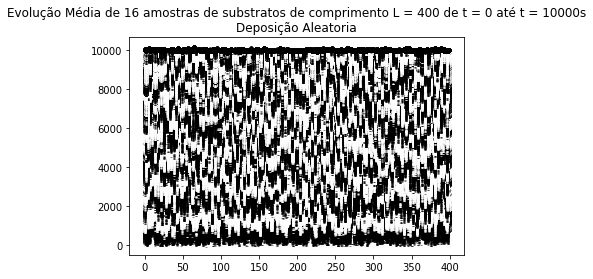

In [7]:
from simulacao_utils import plotar_interface, plotar_rugosidades, plotar_instantaneos

t_comutacao = 25
for L in comprimentos_subestratos:
    plotar_instantaneos(
        'Evolução Média de {} amostras de substratos de comprimento L = {} de t = 0 até t = {}s\n'.format(
            amostras,
            L,
            dados_medios[L]['tempo_maximo']
        )
      + 'Deposição Aleatoria',
        dados_medios[L]['interfaces'],
        [dados_medios[L]['evolucao_subestratos'][t] for t in range(dados_medios[L]['tempo_maximo'])],
        t_comutacao = t_comutacao
    )

## Média das Rugosidades em Função do Tempo - Deposição Aleatória

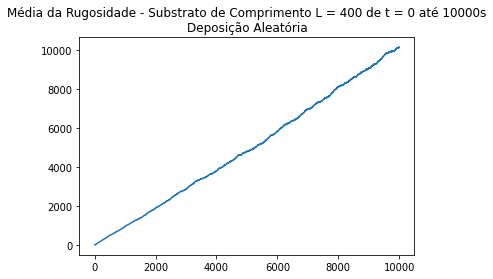

In [8]:
for L in comprimentos_subestratos:
    plotar_rugosidades('Média da Rugosidade - Substrato de Comprimento L = {} de t = 0 até {}s\n'.format(L, dados_medios[L]['tempo_maximo'])
                     + 'Deposição Aleatória',
                      [dados_medios[L]['rugosidades']])

## Salvar os dados para uso posterior

In [9]:
import pickle

for L in comprimentos_subestratos:
    f = open('simulacoes/DA/L_{}'.format(L), 'wb')
    pickle.dump(dados_medios, f)
    f.close()